# Sensor Placement with Unknown Flows

Idea: in the real world, we never know 100% of the ground-truth flows, so passing the true flows into the greedy selection algorithm is not always realistic. 

In [1]:
import networkx as nx
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sensors import flows, utils

## Random Noise

How accurate does our synthetic data have to be for the greedy algorithm to work? Add random noise to the true flows and compare greedy performance to baselines. 

In [12]:
def get_noise_results(G, labeled_edges, noise=4, samples=20):    
    sigma = np.std(list(labeled_edges.values()))    
    c = {}
    
    f = utils.metrics.dict2vect(G, labeled_edges)
        
    for i in range(samples + 1):
        # Add some noise to the flows
        j = noise * i / samples
        noisy_labeled_flows = {s : np.random.normal(scale=j * sigma) + labeled_edges[s] for s in labeled_edges.keys()}
        
        evaluator = flows.lazy.LazyEvaluator(G, noisy_labeled_flows)
        greedy_sensors = evaluator.al_flows_greedy(0.1)
        f_hat = utils.metrics.dict2vect(G, evaluator.predict(greedy_sensors))
        
        c[j] = max(0, np.corrcoef(f, f_hat)[0][1])
    
    return c

In [ ]:
noise = {}
noise["Anaheim"] = get_noise_results(*utils.data.read_tntp_graph("data/Anaheim/Anaheim_flow.tntp"))
noise["Barcelona"] = get_noise_results(*utils.data.read_tntp_graph("data/Barcelona/Barcelona_flow.tntp"))
noise["Chicago"] = get_noise_results(*utils.data.read_tntp_graph("data/Chicago-Sketch/ChicagoSketch_flow.tntp"))
noise["Winnipeg"] = get_noise_results(*utils.data.read_tntp_graph("data/Winnipeg/Winnipeg_flow.tntp"))

 95%|███████████████████████████████████████████████████████████▌   | 279/295 [00:22<00:01, 15.27it/s]

In [14]:
def get_noise_results_maxflow(G, labeled_edges, noise=4, samples=20):    
    sigma = np.std(list(labeled_edges.values()))    
    c = {}
    
    f = utils.metrics.dict2vect(G, labeled_edges)
        
    for i in range(samples + 1):
        # Add some noise to the flows
        j = noise * i / samples
        noisy_labeled_flows = {s : np.random.normal(scale=j * sigma) + labeled_edges[s] for s in labeled_edges.keys()}
        
        evaluator = flows.lazy.LazyEvaluator(G, noisy_labeled_flows)
        max_sensors = evaluator.al_flows_max(0.1)
        f_hat = utils.metrics.dict2vect(G, evaluator.predict(max_sensors))
        
        c[j] = max(0, np.corrcoef(f, f_hat)[0][1])
    
    return c

In [15]:
noise_maxflow = {}
noise_maxflow["Anaheim"] = get_noise_results_maxflow(*utils.data.read_tntp_graph("data/Anaheim/Anaheim_flow.tntp"))
noise_maxflow["Barcelona"] = get_noise_results_maxflow(*utils.data.read_tntp_graph("data/Barcelona/Barcelona_flow.tntp"))
noise_maxflow["Chicago"] = get_noise_results_maxflow(*utils.data.read_tntp_graph("data/Chicago-Sketch/ChicagoSketch_flow.tntp"))
noise_maxflow["Winnipeg"] = get_noise_results_maxflow(*utils.data.read_tntp_graph("data/Winnipeg/Winnipeg_flow.tntp"))

unweighted rrqr


100%|█████████████████████████████████████████████████████████████████| 91/91 [00:05<00:00, 18.04it/s]


unweighted rrqr


100%|███████████████████████████████████████████████████████████████| 252/252 [00:21<00:00, 11.52it/s]


unweighted rrqr


100%|███████████████████████████████████████████████████████████████| 295/295 [00:31<00:00,  9.47it/s]


unweighted rrqr


100%|███████████████████████████████████████████████████████████████| 283/283 [00:28<00:00, 10.04it/s]


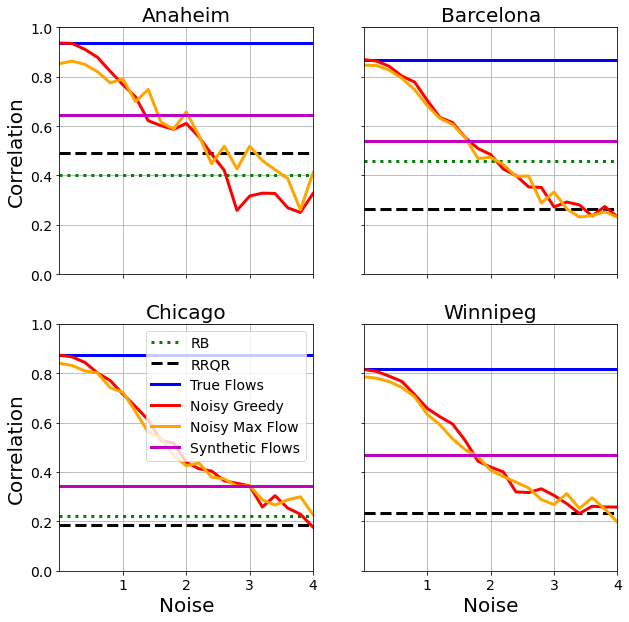

In [30]:
import matplotlib
matplotlib.rc('xtick', labelsize=14) 
matplotlib.rc('ytick', labelsize=14) 

def plot_saved_noise_results(G, labeled_flows, noise_corr, max_corr, ax, title, legend=False, xlabel=False, ylabel=False):
    evaluator = flows.lazy.LazyEvaluator(G, labeled_flows)
    f = utils.metrics.dict2vect(G, labeled_flows)
    
    rb_sensors = evaluator.al_flows_rb(.1)
    f_rb = utils.metrics.dict2vect(G, evaluator.predict(rb_sensors))
    rb_corr = max(0, np.corrcoef(f_rb, f)[0][1])
    
    rrqr_sensors = evaluator.al_flows_rrqr(.1, weighted=False)
    f_rrqr = utils.metrics.dict2vect(G, evaluator.predict(rrqr_sensors))
    rrqr_corr = max(0, np.corrcoef(f_rrqr, f)[0][1])
    
    # Synthetic flow
    synthetic_labels = utils.data.synthetic_flows(G)
    evaluator = flows.lazy.LazyEvaluator(G, synthetic_labels)
    synthetic_sensors = evaluator.al_flows_greedy(.1)
    pred = evaluator.predict(synthetic_sensors)
    synthetic_corr = np.corrcoef(utils.metrics.dict2vect(G, pred), utils.metrics.dict2vect(G, synthetic_labels))[0][1]
    
    ax.plot(noise_corr.keys(), [rb_corr] * len(noise_corr), "g", label="RB", linewidth=3, linestyle="dotted")
    ax.plot(noise_corr.keys(), [rrqr_corr] * len(noise_corr), "black", label="RRQR", linewidth=3, linestyle="dashed")
    ax.plot(noise_corr.keys(), [noise_corr[0]] * len(noise_corr), "b", label="True Flows", linewidth=3)
    ax.plot(noise_corr.keys(), noise_corr.values(), "red", label="Noisy Greedy", linewidth=3)
    ax.plot(max_corr.keys(), max_corr.values(), "orange", label="Noisy Max Flow", linewidth=3)
    ax.plot(noise_corr.keys(), [synthetic_corr] * len(noise_corr), "m", label="Synthetic Flows", linewidth=3)
    
    ax.set_xlim(0, max(noise_corr.keys()))
    ax.set_ylim(0, 1)
    ax.set_title(title, fontsize=20)
    ax.set_xticks([1, 2, 3, 4])
    if legend:
        ax.legend(fontsize=14)
    if xlabel:
        ax.set_xlabel("Noise", fontsize=20)
    else:
        ax.set_xticklabels([])
    if ylabel:
        ax.set_ylabel("Correlation", fontsize=20)
    else:
        ax.set_yticklabels([])
    ax.grid("on")
    
fig, ax = plt.subplots(2, 2, figsize=(10, 10))
plot_saved_noise_results(*utils.data.read_tntp_graph("data/Anaheim/Anaheim_flow.tntp"), noise["Anaheim"], 
                         noise_maxflow["Anaheim"],
                         ax[0][0], "Anaheim",
                        ylabel=True)
plot_saved_noise_results(*utils.data.read_tntp_graph("data/Barcelona/Barcelona_flow.tntp"), noise["Barcelona"], 
                         noise_maxflow["Barcelona"],
                         ax[0][1], 
                         "Barcelona")
plot_saved_noise_results(*utils.data.read_tntp_graph("data/Chicago-Sketch/ChicagoSketch_flow.tntp"), noise["Chicago"],
                        noise_maxflow["Chicago"],
                         ax[1][0], 
                         "Chicago", xlabel=True, ylabel=True, legend=True)
plot_saved_noise_results(*utils.data.read_tntp_graph("data/Winnipeg/Winnipeg_flow.tntp"), noise["Winnipeg"], 
                        noise_maxflow["Winnipeg"],
                         ax[1][1], 
                         "Winnipeg", xlabel=True)
plt.savefig("results/noisy_flows.pdf")